In [1]:
!pip install tqdm

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torch.utils.data import ConcatDataset 
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import tqdm

from torch import tensor
from torchmetrics.classification import MulticlassJaccardIndex

# Load data

In [3]:
# Define a mapping from original class labels in the CityscapesDataset to a reduced set of classes.
LABEL_MAPPING = {
    0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0,
    5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 0,
    10: 0, 11: 2, 12: 2, 13: 2, 14: 0,
    15: 0, 16: 0, 17: 3, 18: 0, 19: 3,
    20: 3, 21: 4, 22: 4, 23: 5, 24: 6,
    25: 6, 26: 7, 27: 7, 28: 7, 29: 0,
    30: 0, 31: 7, 32: 7, 33: 7, -1: 0
}

# Define colors for the new classes for visualization purposes.
LABEL_COLORS = {
    0 : (  0,  0,  0),
    1 : (128, 64,128),
    2 : ( 70, 70, 70),
    3: (153,153,153),
    4: (107,142, 35),
    5: ( 70,130,180),
    6: (220, 20, 60),
    7: (  0,  0,142)
}

# Function to convert the original class labels in an image mask to the new classes.
def mask_to_labels(mask):
    labels = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for label, newlabel in LABEL_MAPPING.items():
        labels[mask == label] = newlabel
    return labels

In [4]:
# Define a PyTorch Dataset class for the Cityscapes dataset.
class CityscapesDataset(Dataset):
    def __init__(self, data_path, list_file, transform=None, transform_type = "", random_rotate_degrees = None, random_color = None):
        # Initialize the class with various parameters.
        # data_path: Path to the directory containing the data.
        # list_file: List of file names to include in the dataset.
        # transform: Optional transformation to apply to the images and masks.
        # transform_type: String to append to the filename when loading an image (e.g., for different versions of the image).
        # random_rotate_degrees: Optional list of degrees to randomly rotate each image.
        # random_color: Optional list of color jitter parameters to apply to each image.
        
        self.data_path = data_path
        self.transform = transform
        self.filenames = []
        self.images = []
        self.transform_type = transform_type

        # If a list of files is provided, use it. Otherwise, find all files in the data_path.
        if list_file is not None:
            for file in list_file:
                self.filenames.append(str(file))
                self.images.append(str(file).split(".png")[0] + transform_type)
        else:
            for root, dirs, files in os.walk(data_path + "/image"):
                for file in files:
                    self.filenames.append(str(file))
                    self.images.append(str(file).split(".png")[0] + transform_type)
                    
        self.random_rotate_degrees = random_rotate_degrees
        self.random_color = random_color

        # Load the dataset into memory.
        self.load_dataset()
        
    def __len__(self):
        # Return the number of samples in the dataset.
        return len(self.filenames)
    
    def load_dataset(self):
        # Load all images and masks into memory.
        self.data = []
        
        for index in range(len(self.filenames)):
            # Load the image and mask.
            image = Image.open(os.path.join(self.data_path + "/image", self.filenames[index])).convert('RGB')
            mask = Image.open(os.path.join(self.data_path + "/mask", self.filenames[index])).convert('L')

            # Convert the mask to the reduced set of labels.
            real_label = mask_to_labels(np.array(mask, dtype=np.uint8))

            # Convert the labels back to a PIL Image.
            real_label = torchvision.transforms.ToPILImage()(real_label)

            # If a transform is specified, apply it to the image and mask.
            if self.transform:
                for t in self.transform.transforms:
                    # If the transform is a custom rotation or color jitter, set the parameters for this image.
                    if isinstance(t, CustomRandomRotation) and self.random_rotate_degrees is not None:
                        t.degrees = self.random_rotate_degrees[index]
                    if isinstance(t, CustomColorJitter) and self.random_color is not None:
                        t.brightness = self.random_color[index][0]
                        t.contrast = self.random_color[index][1]
                        t.saturation = self.random_color[index][2]
                        t.hue = self.random_color[index][3]

                # Apply the transform.
                image, real_label = self.transform(image, real_label)
                # Convert the mask back to a uint8 tensor.
                real_label = (real_label*255).to(torch.uint8)
                
            # Add the image and mask to the dataset.
            self.data.append([image.squeeze(), real_label.squeeze()])
        return self.data
    
    def __getitem__(self, index):
        # Return the specified sample from the dataset.
        return self.data[index]

In [5]:
# Define a custom PyTorch Dataset that concatenates multiple datasets together.
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        # Call the constructor of the parent class.
        super(CustomConcatDataset, self).__init__(datasets)
        
        # Initialize an empty list to hold the images from all datasets.
        self.images = []
        
        # For each dataset, extend the list of images.
        for dataset in datasets:
            self.images.extend(dataset.images)

    def __len__(self):
        # Return the total number of images in all datasets.
        return len(self.images)

In [6]:
import random

def generate_rotate_degrees(num_tuples, seed=42):
    """
    This function generates a list of random integers within a specific range. 
    These integers represent rotation degrees for image augmentation.

    Parameters:
    num_tuples (int): The number of random degrees to generate.
    seed (int): The seed for the random number generator for reproducibility. Default is 42.

    Returns:
    list: A list of random integers between -20 and 20.
    """
    random.seed(seed)  # Set random seed for reproducibility.
    tuples_list = []  # Initialize an empty list to hold the generated degrees.
    
    for _ in range(num_tuples):  # Generate the specified number of random degrees.
        value = random.randint(-20, 20)  # Generate a random degree.
        tuples_list.append(value)  # Add the generated degree to the list.
    
    return tuples_list  # Return the list of generated degrees.

def generate_color_param(num_tuples, seed=42):
    """
    This function generates a list of tuples, where each tuple contains four random float 
    values representing parameters for brightness, contrast, saturation, and hue transformations. 
    These parameters can be used for image augmentation.

    Parameters:
    num_tuples (int): The number of tuples to generate.
    seed (int): The seed for the random number generator for reproducibility. Default is 42.

    Returns:
    list: A list of tuples, each containing four random float values.
    """
    random.seed(seed)  # Set random seed for reproducibility.
    tuples_list = []  # Initialize an empty list to hold the generated tuples.
    
    for _ in range(num_tuples):  # Generate the specified number of tuples.
        bright = random.uniform(0.5, 2.5)  # Generate a random brightness value.
        contrast = random.uniform(0.5, 3)  # Generate a random contrast value.
        saturation = random.uniform(0.5, 1)  # Generate a random saturation value.
        hue = random.uniform(-0.3, 0.3)  # Generate a random hue value.
        
        tuples_list.append((bright, contrast, saturation, hue))  # Add the generated tuple to the list.
    
    return tuples_list  # Return the list of generated tuples.

In [7]:
import torchvision.transforms.functional as F

class CustomColorJitter(object):
    """
    This class defines a custom color jitter transformation. It adjusts the brightness, 
    contrast, saturation, and hue of the input image. The transformation is applied 
    to the image but not the mask.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, image, mask):
        # Apply the color jitter transformations to the image.
        image = F.adjust_brightness(image, self.brightness)
        image = F.adjust_contrast(image, self.contrast)
        image = F.adjust_saturation(image, self.saturation)
        image = F.adjust_hue(image, self.hue)

        return image, mask

class CustomRandomRotation(object):
    """
    This class defines a custom random rotation transformation. It rotates the input image 
    and mask by a specified degree.
    """
    def __init__(self, degrees=0):
        self.degrees = degrees

    def __call__(self, image, mask):
        # Rotate the image and mask by the specified degree.
        return F.rotate(image, self.degrees), F.rotate(mask, self.degrees)

class CustomFlip(object):
    """
    This class defines a custom horizontal flip transformation. It flips the input image 
    and mask horizontally.
    """
    def __init__(self, probs=1):
        pass

    def __call__(self, image, mask):
        # Flip the image and mask horizontally.
        return F.hflip(image), F.hflip(mask)

class CustomCompose(object):
    """
    This class defines a custom compose transformation. It applies a list of transformations 
    sequentially to the input image and mask.
    """
    def __init__(self, transforms=[]):
        self.transforms = transforms

    def __call__(self, image, mask):
        # Apply each transformation in the list to the image and mask.
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

class CustomToTensor(transforms.ToTensor):
    """
    This class defines a custom ToTensor transformation. It converts the input image 
    and mask from PIL Image or numpy.ndarray to torch.Tensor.
    """
    def __call__(self, image, mask):
        # Convert the image and mask to torch.Tensor.
        return super().__call__(image), super().__call__(mask)

In [8]:
# Creating a list of all image file names in the training directory
list_file = []
for root, dirs, files in os.walk("/kaggle/input/hcmus-cv-cityscape-dataset/data/train/image"):
    for file in files:
        list_file.append(file)

# Splitting the list of file names into two halves
first_half = list_file[:len(list_file)//2]
second_half = list_file[len(list_file)//2:]

# Defining several data transformations
original_transform = CustomCompose([CustomToTensor()])
rotated_transform = CustomCompose([CustomRandomRotation(), CustomToTensor()])
flipped_transform = CustomCompose([CustomFlip(probs=1), CustomToTensor()])
colored_transform = CustomCompose([CustomColorJitter(), CustomToTensor()])
colored_flipped_transform = CustomCompose([CustomColorJitter(), CustomFlip(probs=1), CustomToTensor()])

# Creating datasets with different transformations
original_dataset = CityscapesDataset(data_path= "/kaggle/input/hcmus-cv-cityscape-dataset/data/train", 
                                     list_file= list_file,
                                     transform = original_transform)

rotated_dataset = CityscapesDataset(data_path= "/kaggle/input/hcmus-cv-cityscape-dataset/data/train",
                                    list_file= first_half,
                                    transform = rotated_transform, 
                                    transform_type = "_rotate",
                                    random_rotate_degrees= generate_rotate_degrees(len(first_half)))

flipped_dataset = CityscapesDataset(data_path="/kaggle/input/hcmus-cv-cityscape-dataset/data/train",
                                    list_file= second_half,
                                    transform = flipped_transform, 
                                    transform_type = "_flip")

colored_dataset = CityscapesDataset(data_path="/kaggle/input/hcmus-cv-cityscape-dataset/data/train",
                                    list_file= first_half,
                                    transform = colored_transform,
                                    transform_type = "_color",
                                    random_color=generate_color_param(len(first_half)))

colored_flipped_dataset = CityscapesDataset(data_path="/kaggle/input/hcmus-cv-cityscape-dataset/data/train",
                                            list_file= second_half,
                                            transform = colored_flipped_transform,
                                            transform_type = "_color_flip",
                                            random_color=generate_color_param(len(second_half)))

# Concatenating all datasets into one for training
train_dataset = CustomConcatDataset([original_dataset, rotated_dataset, flipped_dataset, colored_dataset, colored_flipped_dataset])

# Print the total number of samples in the concatenated dataset
len(train_dataset)

8925

In [9]:
val_dataset = CityscapesDataset(data_path= "/kaggle/input/hcmus-cv-cityscape-dataset/data/val", 
                                list_file = None,
                                transform = original_transform)

In [10]:
list_data_for_draw_test = []
for i in [1,2,3,4,8]:
    list_data_for_draw_test.append(train_dataset[i])

In [11]:
# Convert a Label Image (grayscale) to Segmentation Image (RGB)
def label_to_segment_image(label):
    ndarray_label = np.array(label).squeeze()
    segment_image = np.zeros((ndarray_label.shape[0], ndarray_label.shape[1], 3), dtype = np.uint8)
    
    for label_value, color in LABEL_COLORS.items():
        segment_image[ndarray_label == label_value] = color
    segment_image = Image.fromarray(segment_image)
    return segment_image

In [12]:
def prepare_dataloader(dataset, batch_size, num_workers):
    return DataLoader(dataset,num_workers = 4, batch_size = batch_size)

# Model architecture

In [14]:
def conv_block(in_channels, out_channels, activate_function=None, kernel_size=3, stride=1, padding=1, bias=True):
    """
    This function defines a convolutional block consisting of a 2D convolution layer followed by a batch normalization layer.
    If an activation function is provided, it is appended to the block.
    """
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_channels)
    )
    
    if activate_function is not None:
        block.append(activate_function)
    
    return block

def max_pool(kernel_size=2, stride=2, padding=0):
    """
    This function defines a max pooling layer.
    """
    pool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
    return pool

def conv_trans_block(in_channels, out_channels, activate_function, kernel_size=3, stride=2, padding=1, output_padding=1):
    """
    This function defines a transposed convolutional block consisting of a 2D transposed convolution layer, 
    a batch normalization layer, and an activation function.
    """
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),
        nn.BatchNorm2d(out_channels),
        activate_function
    )
    return block

def up_sample(mode="bilinear"):
    """
    This function defines an upsampling layer.
    """
    return nn.Upsample(scale_factor=2, mode=mode, align_corners=True)

def conv_block_2(in_channels, out_channels, activate_function, mid_channels=None, kernel_size=3, stride=1, padding=1):
    """
    This function defines a convolutional block consisting of two convolutional blocks.
    If the mid_channels argument is not provided, it is set to be equal to out_channels.
    """
    if mid_channels is None:
        mid_channels = out_channels
    block = nn.Sequential(
        conv_block(in_channels, mid_channels, activate_function, kernel_size=kernel_size, stride=stride),
        conv_block(mid_channels, out_channels, activate_function, kernel_size=kernel_size, stride=stride),
    )
    return block

In [15]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_x, F_int):
        """
        This constructor initializes the attention gate with three convolutional blocks.
        - F_g, F_x, and F_int are the number of channels for the gate signal, the input features, and the intermediate features, respectively.
        - W_x and W_g are 1x1 convolutions used to match the number of channels between the gate signal and the input features.
        - psi is a 1x1 convolution followed by a sigmoid activation function, which is used to output the attention coefficients.
        """
        super(AttentionGate, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        
        self.W_x = conv_block(F_x, F_int, kernel_size=1, stride=1, padding=0, bias=False)
        self.W_g = conv_block(F_g, F_int, kernel_size=1, stride=1, padding=0)
        self.psi = conv_block(F_int, 1, activate_function=nn.Sigmoid(), kernel_size=1, stride=1, padding=0)
    
    def forward(self, gate, skip_connection):
        """
        This method defines the forward pass of the attention gate.
        - The gate signal and the input features are first passed through W_g and W_x, respectively.
        - The output features are then added together and passed through a ReLU activation function.
        - The result is passed through psi to get the attention coefficients.
        - The attention coefficients are multiplied element-wise with the input features to get the output features.
        """
        g = self.W_g(gate)
        x = self.W_x(skip_connection)
        q = self.relu(g + x)
        psi = self.psi(q)
        out = psi * skip_connection
        return out

In [16]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_filter, mode="bilinear"):
        """
        This constructor initializes the Attention U-Net. It includes a down path (encoder), a bridge (bottom-most layer), 
        an up path (decoder), and attention gates for the up path.
        """
        super(AttentionUNet, self).__init__()

        # Activation function
        self.activate_function = nn.ReLU(inplace=True)

        # Network parameters
        self.num_filter = num_filter
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mode = mode

        # Down path (encoder)
        self.down_block_1 = conv_block_2(self.in_channels, self.num_filter, self.activate_function)
        self.max_pool_block_1 = max_pool()
        self.down_block_2 = conv_block_2(self.num_filter, self.num_filter*2, self.activate_function)
        self.max_pool_block_2 = max_pool()
        self.down_block_3 = conv_block_2(self.num_filter*2, self.num_filter*4, self.activate_function)
        self.max_pool_block_3 = max_pool()
        self.down_block_4 = conv_block_2(self.num_filter*4, self.num_filter*8, self.activate_function)
        self.max_pool_block_4 = max_pool()

        # Bridge
        self.bridge = conv_block_2(self.num_filter*8, self.num_filter*8, self.activate_function, self.num_filter*16)

        # Up path (decoder)
        self.trans_block_1 = up_sample(mode=mode)
        self.trans_block_2 = up_sample(mode=mode)
        self.trans_block_3 = up_sample(mode=mode)
        self.trans_block_4 = up_sample(mode=mode)
        self.up_block_1 = conv_block_2(self.num_filter*16, self.num_filter*4, self.activate_function, self.num_filter*8)
        self.up_block_2 = conv_block_2(self.num_filter*8, self.num_filter*2, self.activate_function, self.num_filter*4)
        self.up_block_3 = conv_block_2(self.num_filter*4, self.num_filter, self.activate_function, self.num_filter*2)
        self.up_block_4 = conv_block_2(self.num_filter*2, self.num_filter, self.activate_function)

        # Attention gates for up path
        self.gate_1 = AttentionGate(self.num_filter*8, self.num_filter*8, self.num_filter*4)
        self.gate_2 = AttentionGate(self.num_filter*4, self.num_filter*4, self.num_filter*2)
        self.gate_3 = AttentionGate(self.num_filter*2, self.num_filter*2, self.num_filter)
        self.gate_4 = AttentionGate(self.num_filter, self.num_filter, self.num_filter//2)

        # Output layer
        self.output = nn.Sequential(
                nn.Conv2d(self.num_filter, self.out_channels, kernel_size=1),
            )

    def forward(self, x):
        """
        This method defines the forward pass of the Attention U-Net.
        The input is passed through the down path, the bridge, and the up path.
        Attention gates are applied at each layer of the up path.
        """
        # Down path
        down_1 = self.down_block_1(x)
        pool_1 = self.max_pool_block_1(down_1)
        down_2 = self.down_block_2(pool_1)
        pool_2 = self.max_pool_block_2(down_2)
        down_3 = self.down_block_3(pool_2)
        pool_3 = self.max_pool_block_3(down_3)
        down_4 = self.down_block_4(pool_3)
        pool_4 = self.max_pool_block_4(down_4)

        # Bridge
        bridge = self.bridge(pool_4)

        # Up path with attention gates
        trans_1 = self.trans_block_1(bridge)
        atten_1 = self.gate_1(trans_1, down_4)
        concat_connect_1 = torch.cat([atten_1, trans_1], dim=1)
        up_1 = self.up_block_1(concat_connect_1)

        trans_2 = self.trans_block_2(up_1)
        atten_2 = self.gate_2(trans_2, down_3)
        concat_connect_2 = torch.cat([trans_2, atten_2], dim=1)
        up_2 = self.up_block_2(concat_connect_2)

        trans_3 = self.trans_block_3(up_2)
        atten_3 = self.gate_3(trans_3, down_2)
        concat_connect_3 = torch.cat([trans_3, atten_3], dim=1)
        up_3 = self.up_block_3(concat_connect_3)

        trans_4 = self.trans_block_4(up_3)
        atten_4 = self.gate_4(trans_4, down_1)
        concat_connect_4 = torch.cat([trans_4, atten_4], dim=1)
        up_4 = self.up_block_4(concat_connect_4)

        # Output layer
        out = self.output(up_4)

        return out

    @staticmethod
    def init_weight(m):
        """
        This method initializes the weights of the 2D convolution layers with normal distribution and biases with zeros.
        """
        if isinstance(m, nn.Conv2d):
            torch.nn.init.normal_(m.weight, 0.0, 2/(m.kernel_size[0]*m.kernel_size[1]*m.out_channels))
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

# Model training

In [17]:
def plot_result(image, prediction, mask):
    """
    This function plots the original image, the original segmentation (mask), and the predicted segmentation.
    It takes an image, a prediction, and a mask as input, all of which are tensors.
    The tensors are first moved to the CPU, and then plotted using matplotlib.
    """
    # Move tensors to CPU
    image, prediction, mask = image.cpu(), prediction.cpu(), mask.cpu()
    
    # Create a new figure with a specified size
    plt.figure(figsize=(15,5))
    
    # Plot original image
    plt.subplot(1,3,1)  # Subplot with 1 row and 3 columns, this is the first subplot
    plt.imshow(transforms.ToPILImage()(image).convert("RGB"))  # Convert tensor image to PIL image and then to RGB
    plt.title("Original Image")  # Set title for subplot
    plt.axis("off")  # Hide axes
    
    # Plot original segmentation (mask)
    plt.subplot(1,3,2)  # Subplot with 1 row and 3 columns, this is the second subplot
    plt.imshow(label_to_segment_image(mask))  # Convert label to segmentation image using a helper function
    plt.title("Original Segmentation")  # Set title for subplot
    plt.axis("off")  # Hide axes

    # Plot predicted segmentation
    plt.subplot(1,3,3)  # Subplot with 1 row and 3 columns, this is the third subplot
    plt.imshow(label_to_segment_image(prediction))  # Convert prediction to segmentation image using a helper function
    plt.title("Prediction")  # Set title for subplot
    plt.axis("off")  # Hide axes

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [19]:
# model initialization
model = AttentionUNet(in_channels=3, 
                      out_channels=8, 
                      num_filter=64, 
                      mode="bilinear").float() \
                                  .apply(AttentionUNet.init_weight) \
                                  .to(device)

In [20]:
# Set the learning rate and number of epochs
lr = 0.01 
num_epochs = 25

# Prepare data loaders for training and validation datasets. Batch size is 32 and number of workers is 4.
train_dataloader = prepare_dataloader(train_dataset, 32, 4)
val_dataloader = prepare_dataloader(val_dataset, 32, 4)

# Set up the optimizer - Adam with learning rate 'lr' and weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-5)

# Set up learning rate scheduler to adjust learning rate at epochs 8 and 16
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16], gamma=0.1)

# Set the loss function to CrossEntropyLoss for classification tasks
loss = nn.CrossEntropyLoss()

# Set up Jaccard Index as the evaluation metric, ignoring the background class (index 0)
metric = MulticlassJaccardIndex(num_classes=8, ignore_index= 0).to(device)

100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 1 - Training loss: 0.9544149365903656 - Validation loss: 0.8522158451378345 - MeanIoU: 0.3172262907028198


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 2 - Training loss: 0.6597249160744383 - Validation loss: 0.7279830649495125 - MeanIoU: 0.42075127363204956


100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 3 - Training loss: 0.5615582639171232 - Validation loss: 0.6094407625496387 - MeanIoU: 0.49614769220352173


100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 4 - Training loss: 0.5076311913228804 - Validation loss: 0.5501748248934746 - MeanIoU: 0.538884162902832


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 5 - Training loss: 0.47312816090908527 - Validation loss: 0.5183131396770477 - MeanIoU: 0.5534530282020569


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 6 - Training loss: 0.44302819311405167 - Validation loss: 0.49409699998795986 - MeanIoU: 0.5798161625862122


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 7 - Training loss: 0.4225603846238933 - Validation loss: 0.4806782491505146 - MeanIoU: 0.587515115737915


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 8 - Training loss: 0.39994494739826436 - Validation loss: 0.4572676941752434 - MeanIoU: 0.603256344795227


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 9 - Training loss: 0.38152712177632103 - Validation loss: 0.46135253459215164 - MeanIoU: 0.6211438179016113


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 10 - Training loss: 0.36637556798569193 - Validation loss: 0.46274702809751034 - MeanIoU: 0.6152753829956055


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 11 - Training loss: 0.3600270276001277 - Validation loss: 0.4667670428752899 - MeanIoU: 0.6048973798751831


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 12 - Training loss: 0.34774112097892285 - Validation loss: 0.4862825367599726 - MeanIoU: 0.5856557488441467


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 13 - Training loss: 0.33963412842229274 - Validation loss: 0.4200401622802019 - MeanIoU: 0.637352705001831


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 14 - Training loss: 0.3293715389078236 - Validation loss: 0.4388113524764776 - MeanIoU: 0.6122096180915833


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 15 - Training loss: 0.32393316011275014 - Validation loss: 0.4218531772494316 - MeanIoU: 0.645088791847229


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 16 - Training loss: 0.3173021939599813 - Validation loss: 0.4178198389708996 - MeanIoU: 0.643921971321106


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 17 - Training loss: 0.3147040096021468 - Validation loss: 0.4239489044994116 - MeanIoU: 0.6290829181671143


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 18 - Training loss: 0.30544197094696823 - Validation loss: 0.4014526195824146 - MeanIoU: 0.6747279167175293


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 19 - Training loss: 0.30598955278328244 - Validation loss: 0.42866245470941067 - MeanIoU: 0.6412845849990845


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 20 - Training loss: 0.2730242513307107 - Validation loss: 0.34115673042833805 - MeanIoU: 0.731367826461792


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]
/tmp/ipykernel_23/4239069169.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))


Epoch 21 - Training loss: 0.24768908401971224 - Validation loss: 0.3489542491734028 - MeanIoU: 0.7359341979026794


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 22 - Training loss: 0.23397461845669695 - Validation loss: 0.35995352640748024 - MeanIoU: 0.737665057182312


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 23 - Training loss: 0.22270755832981465 - Validation loss: 0.3747150357812643 - MeanIoU: 0.7382638454437256


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 24 - Training loss: 0.21287466382681255 - Validation loss: 0.38302694633603096 - MeanIoU: 0.7401188611984253


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 25 - Training loss: 0.205964142650259 - Validation loss: 0.3849337808787823 - MeanIoU: 0.7363744974136353


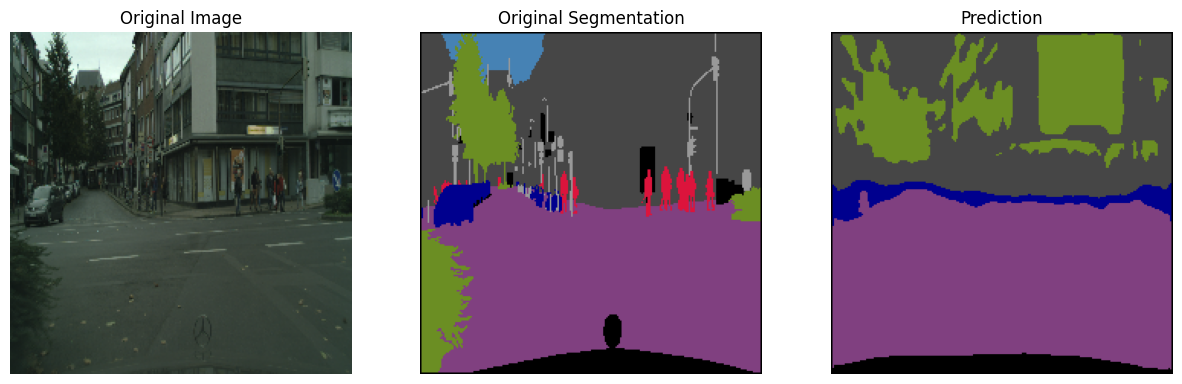

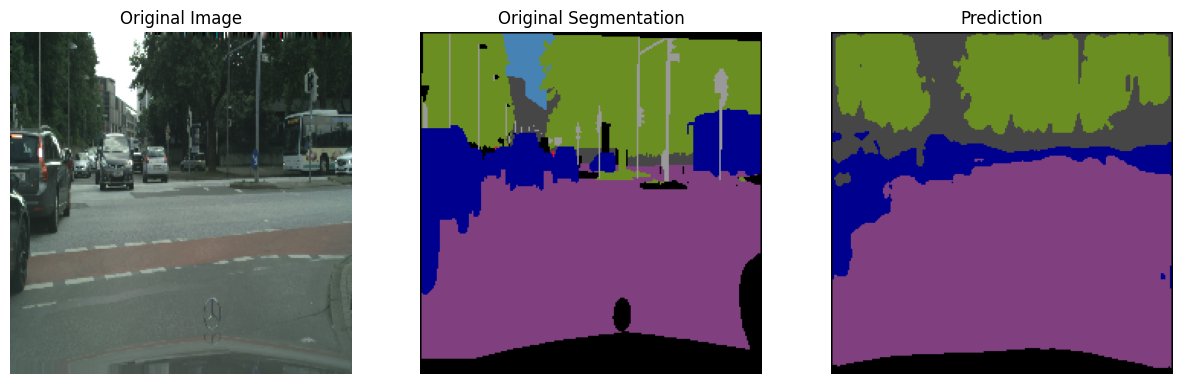

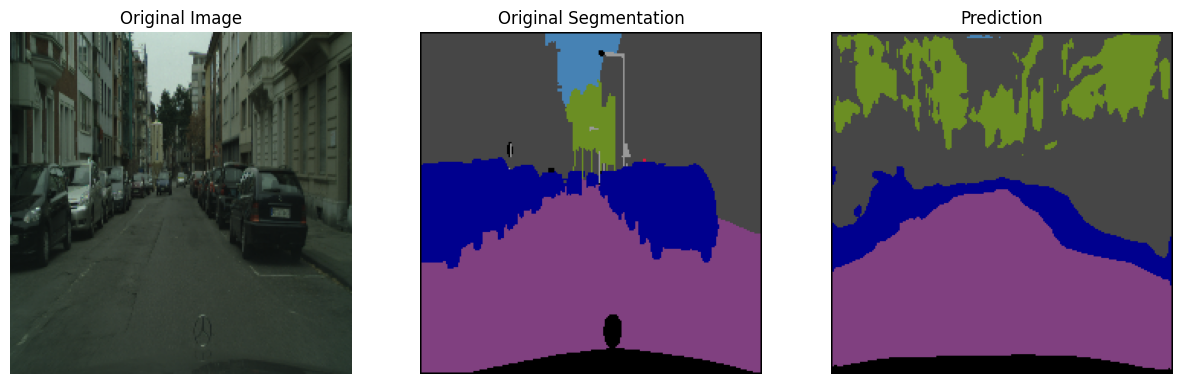

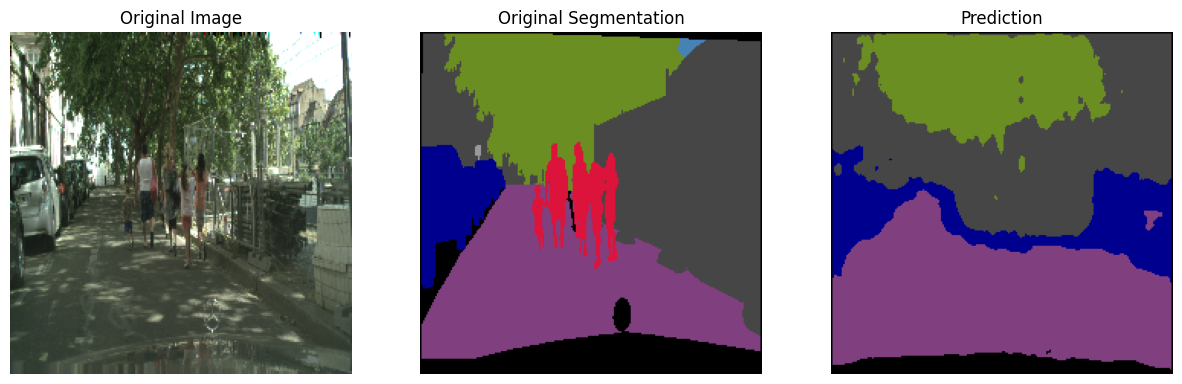

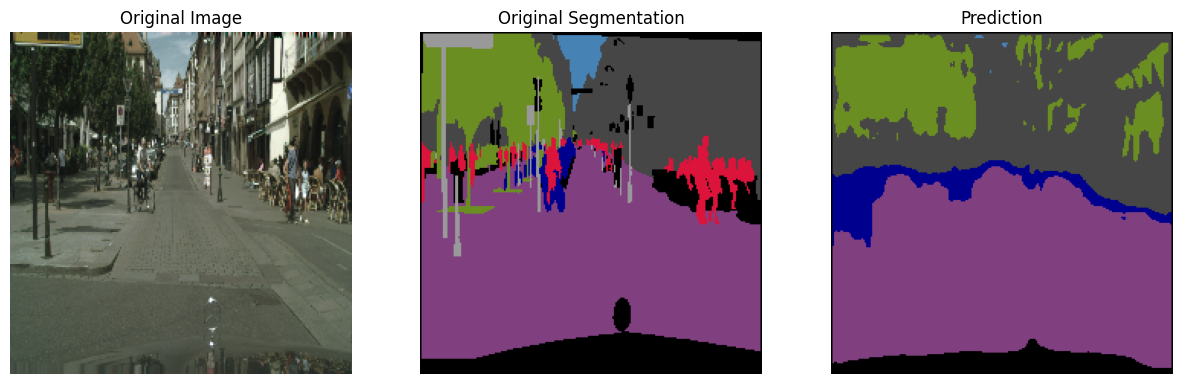

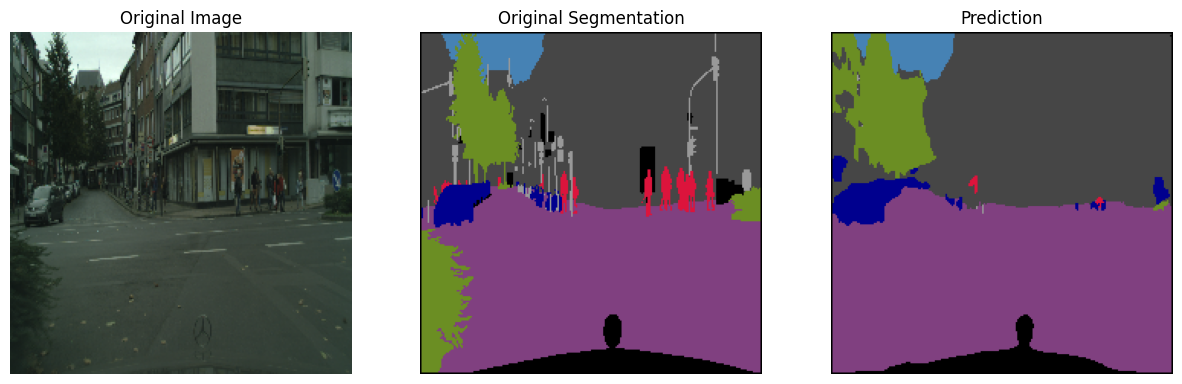

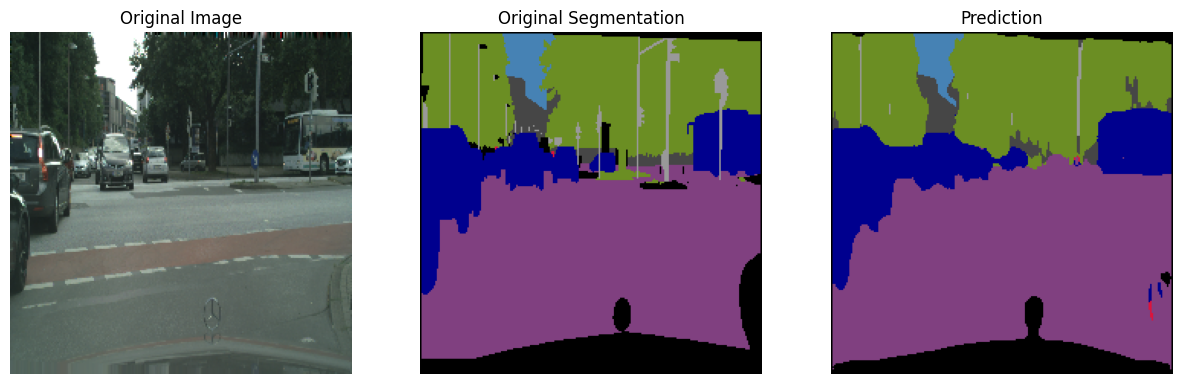

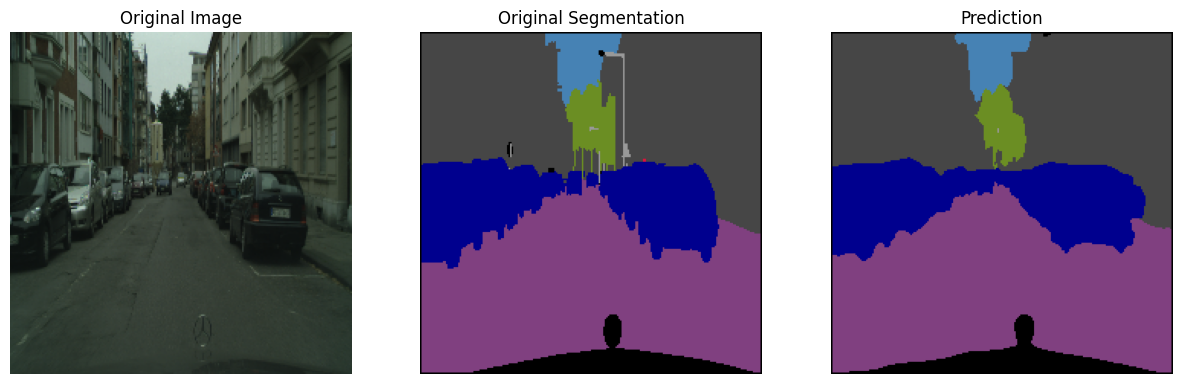

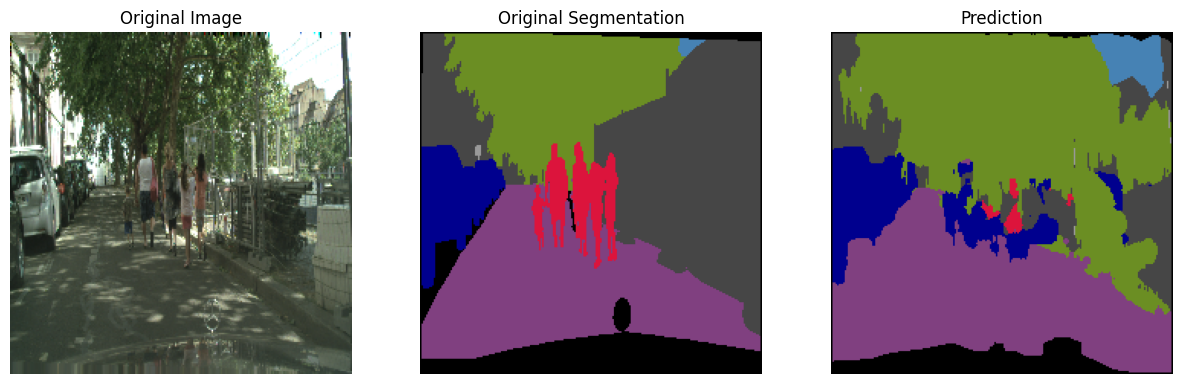

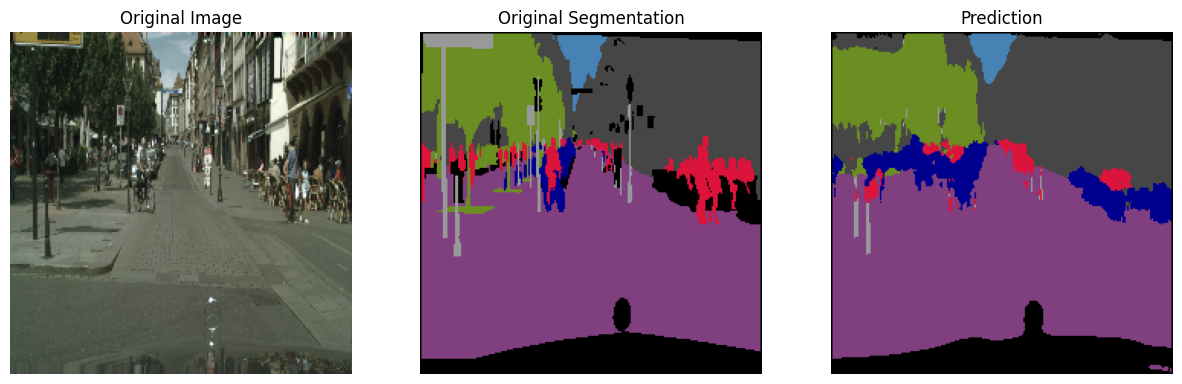

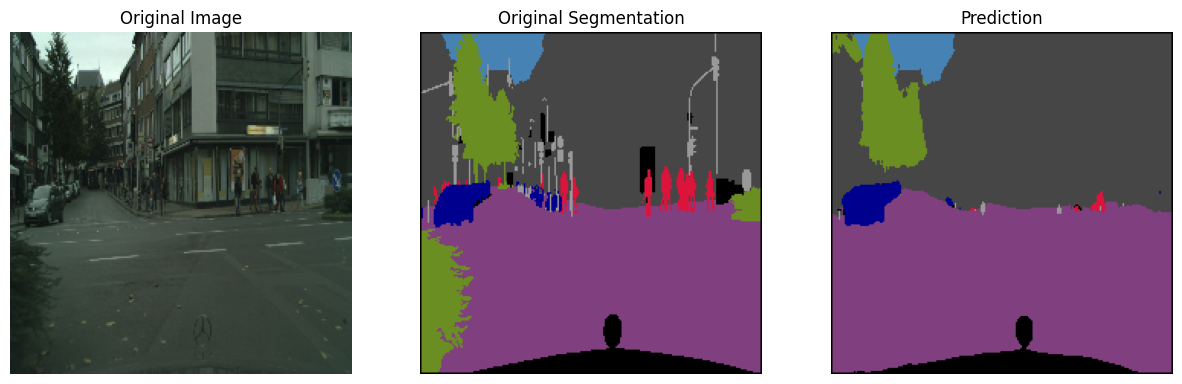

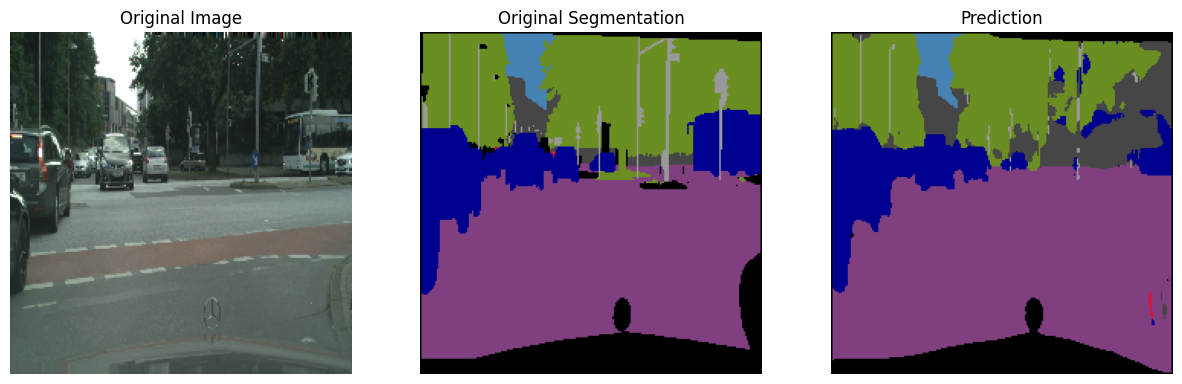

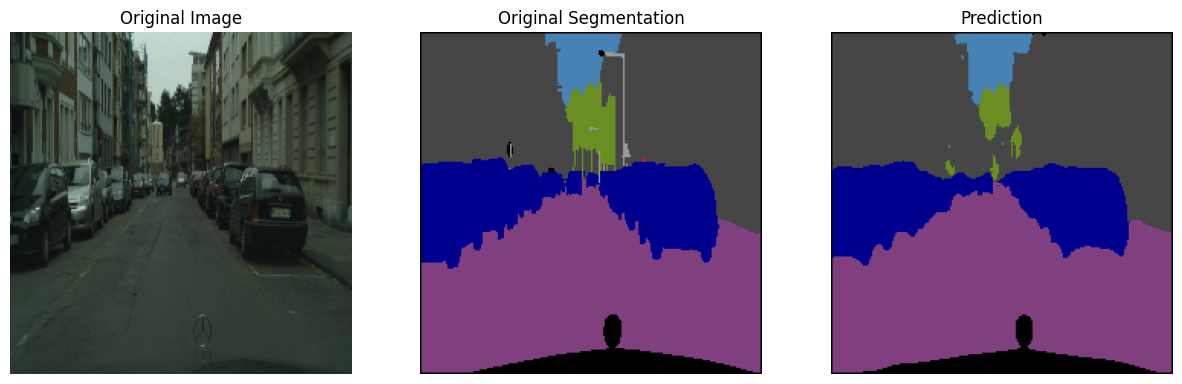

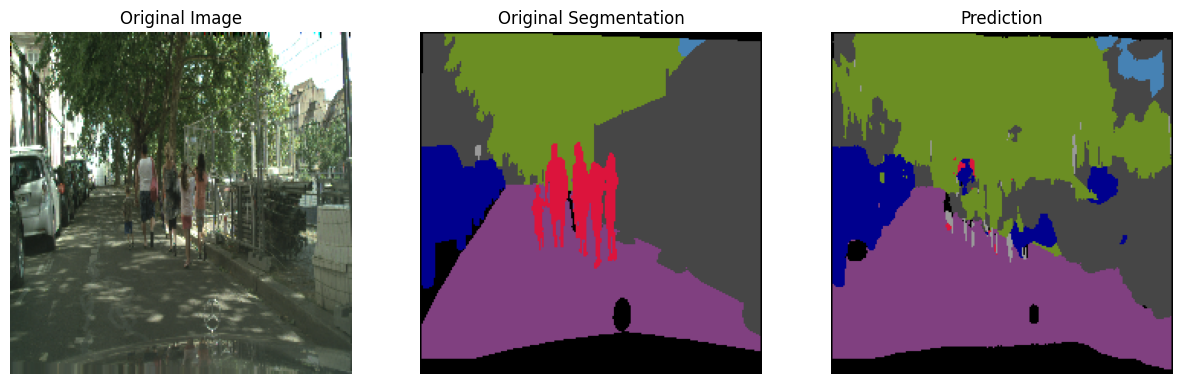

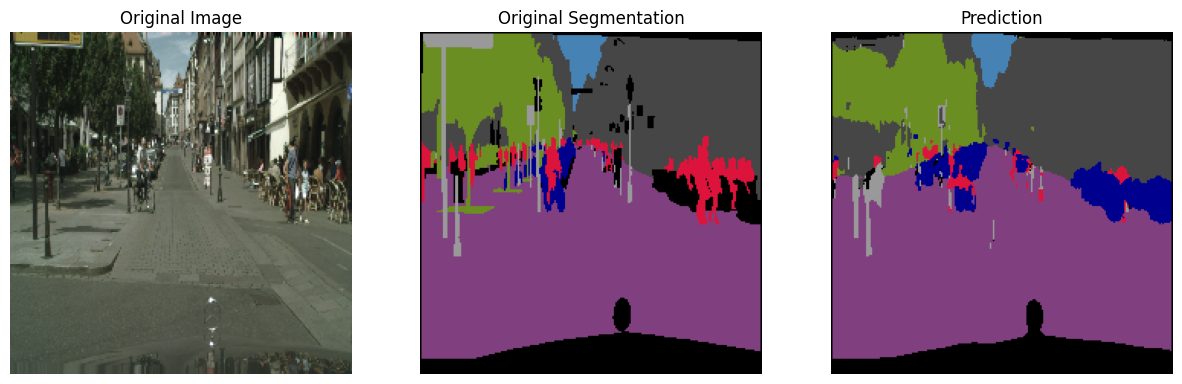

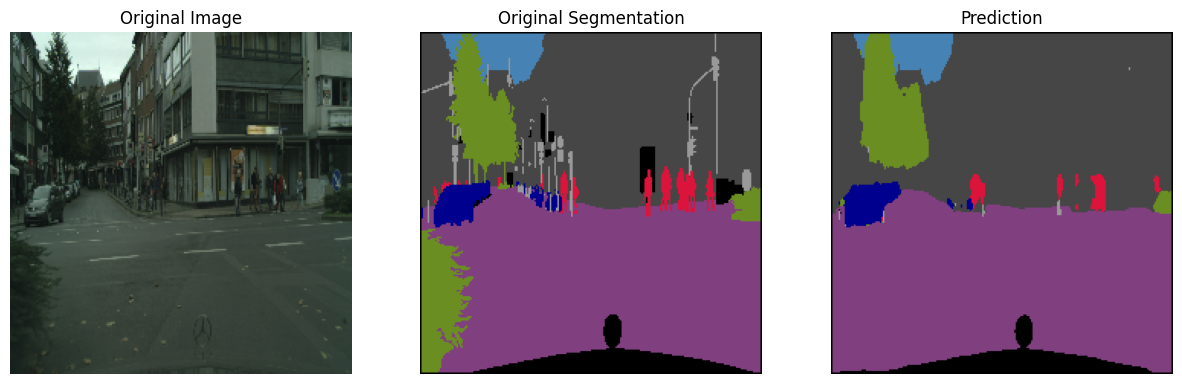

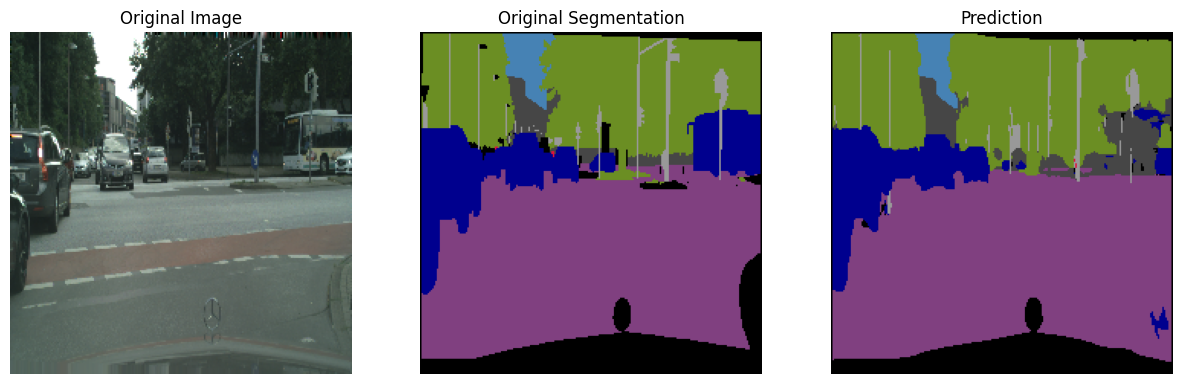

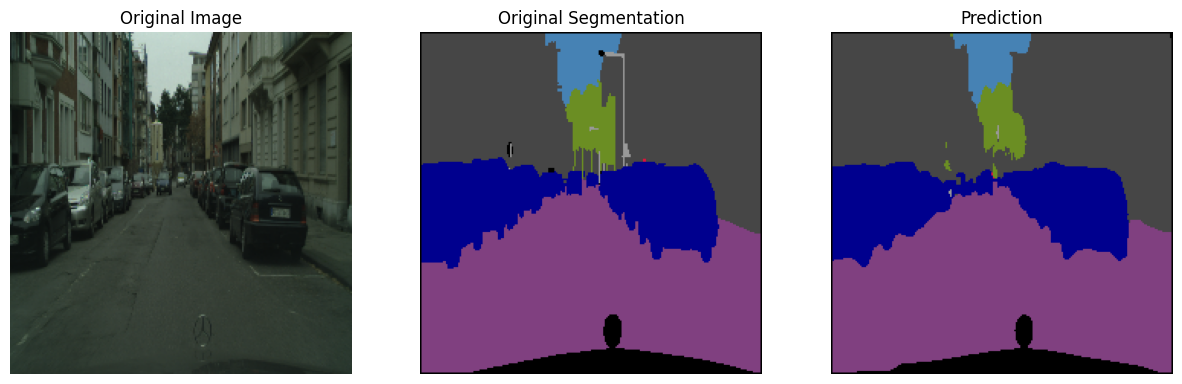

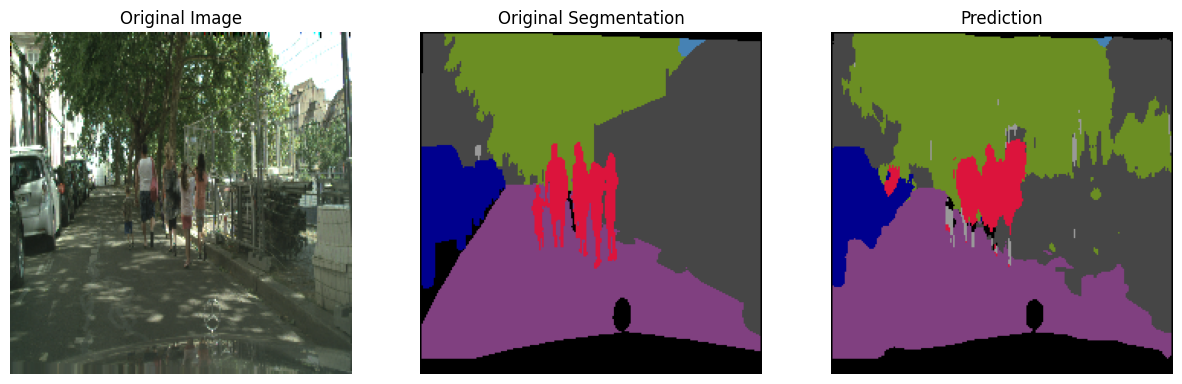

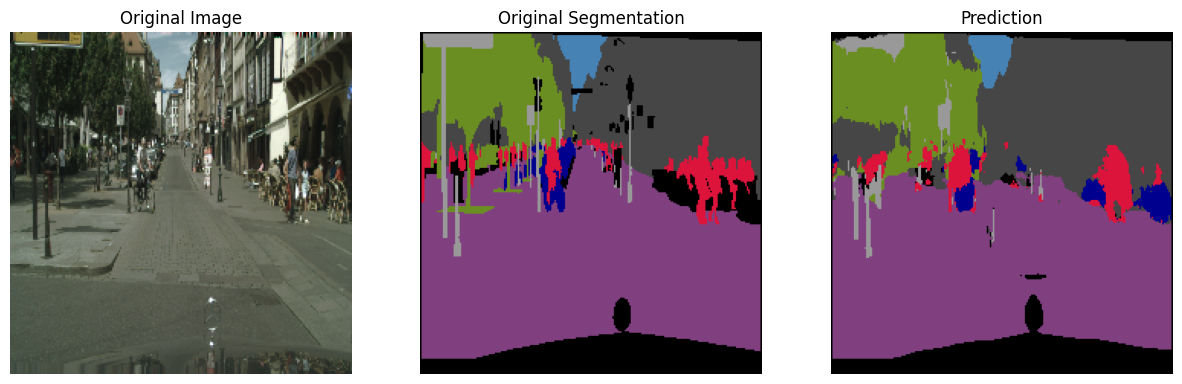

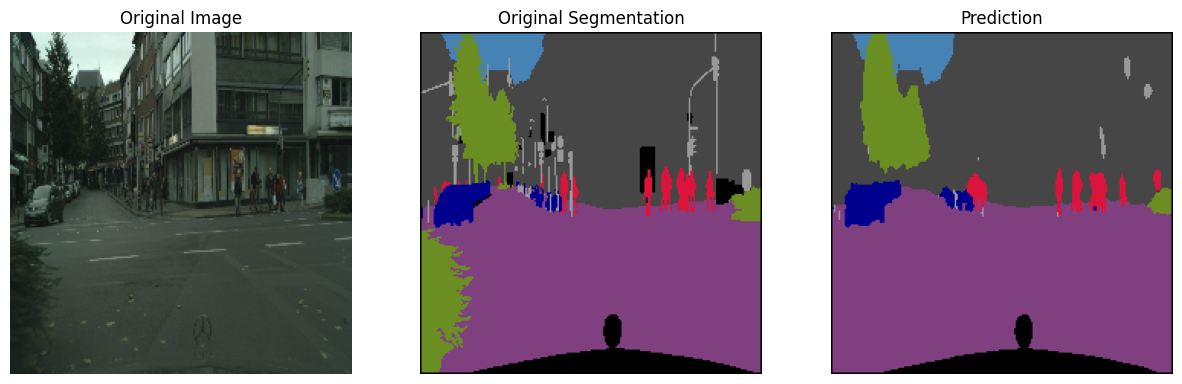

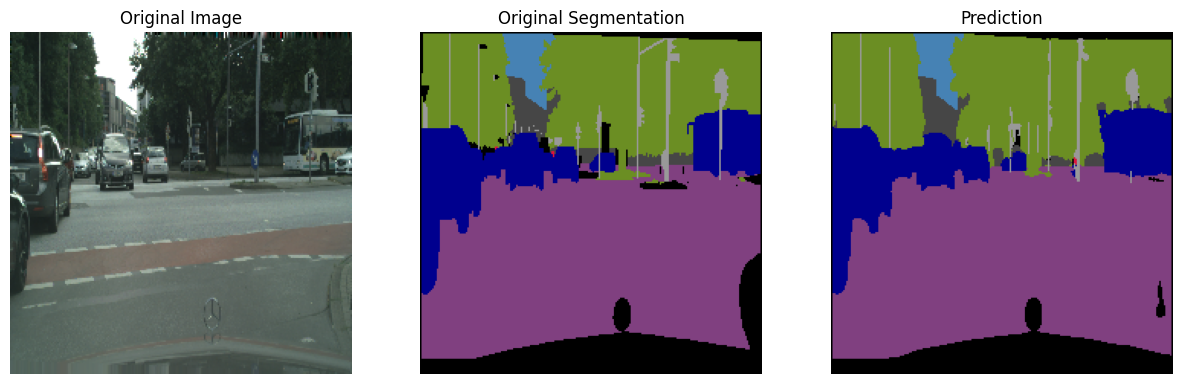

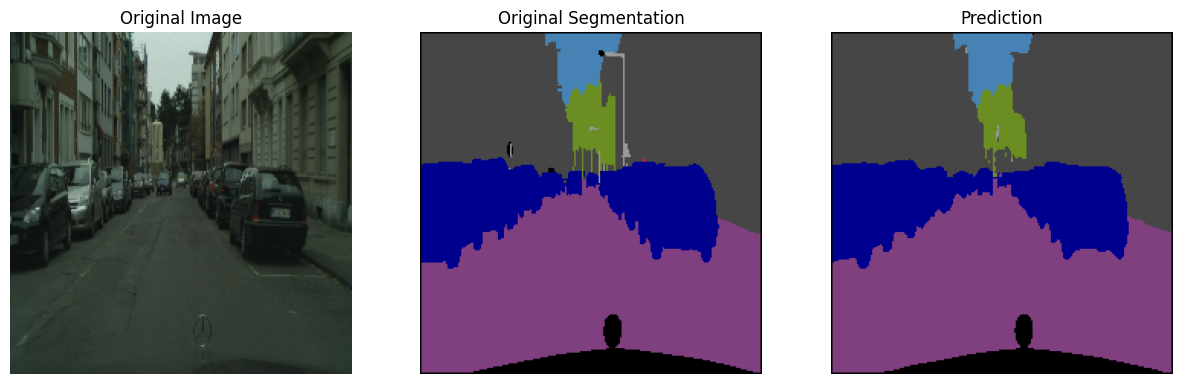

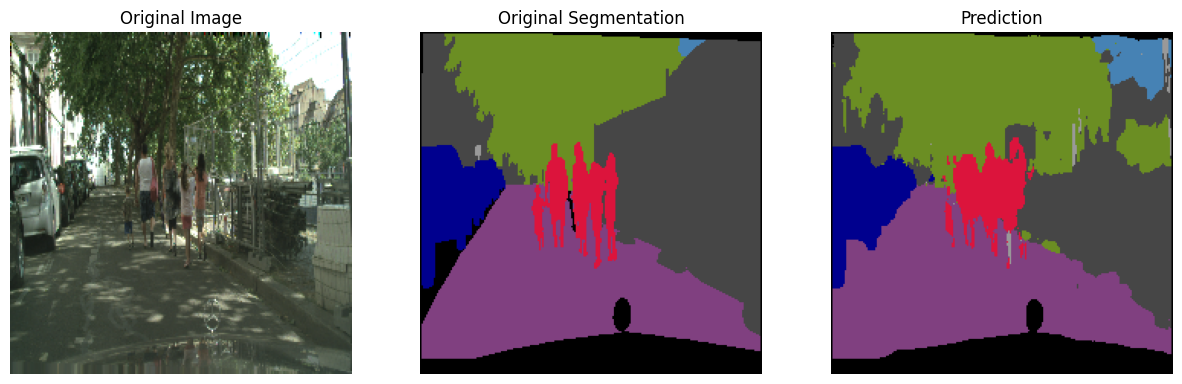

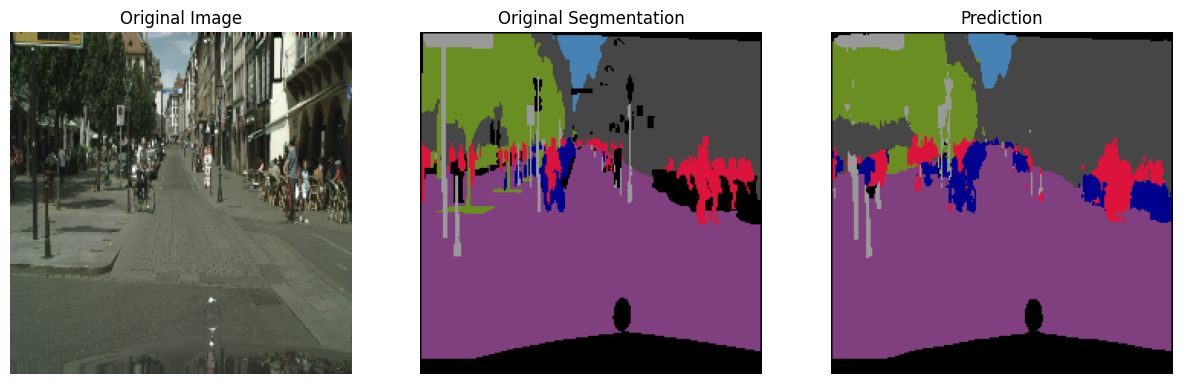

In [21]:
# Initialize an empty list to store training loss history
history_train_loss = []

# Initialize the best validation loss to infinity
best_val_loss = float("inf")

# Set patience for early stopping
patience = 10
current_patience = 0

# Loop over each epoch
for epoch in range(num_epochs):
    # Initialize running loss to 0
    running_loss = 0
    # Set the model to training mode
    model.train()

    # Loop over each batch in the training data loader
    for image, label in tqdm.tqdm(train_dataloader):
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Move the images and labels to the specified device
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(image)
        # Calculate the batch loss
        train_loss = loss(output, label.type(torch.LongTensor).to(device))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        train_loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Update running training loss
        running_loss += train_loss.item()
    
    # Calculate average training loss over an epoch
    avg_train_loss = running_loss/len(train_dataloader)
    # Append average training loss to the history
    history_train_loss.append(avg_train_loss)
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize validation loss to 0
    val_loss = 0
    # Initialize lists to store predictions and labels
    predictions = []
    labels = []
    # Turn off the gradient for validation, saves memory and computations
    with torch.no_grad():
        # Loop over each batch in the validation data loader
        for image, label in tqdm.tqdm(val_dataloader):
            # Move images and labels to the specified device
            image = image.to(device)
            label = label.to(device)
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(image)
            # Update validation loss
            val_loss += loss(output, label.type(torch.LongTensor).to(device)).item()
            
            # Append current batch of predictions and labels to the list
            predictions.append(output)
            labels.append(label)
            
    # Calculate average validation loss over an epoch
    avg_val_loss = val_loss/len(val_dataloader)
    # Concatenate all predictions and labels along the batch dimension
    predictions = torch.cat(predictions, dim = 0)
    # Get the index of the max log-probability
    predictions = torch.argmax(predictions, dim=1)
    # Concatenate all labels along the batch dimension
    labels = torch.cat(labels, dim = 0)
    
    # Calculate the mean IoU metric
    mean_iou = metric(predictions, labels)
    # Print training and validation loss and mean IoU for this epoch
    print(f"Epoch {epoch + 1} - Training loss: {avg_train_loss} - Validation loss: {avg_val_loss} - MeanIoU: {mean_iou}")
        
    # Plot results every 5 epochs
    if (epoch % 5 == 0):
        for image_draw_test, label_draw_test in list_data_for_draw_test:
            # Make predictions for test images
            pred = model(image_draw_test.unsqueeze(0).to(device))
            # Get the index of the max log-probability
            pred = torch.argmax(pred, dim = 1).to("cpu")
            # Plot the original image, true mask, and predicted mask
            plot_result(image_draw_test, pred, label_draw_test)
    
    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        current_patience = 0
        # Save model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        # If validation loss has not decreased, increment patience counter
        current_patience += 1
        # If patience counter has reached the limit, stop training
        if current_patience >= patience:
            print(f"Early stopping after {epoch} epochs")
            break
    # Step the scheduler
    scheduler.step()

In [24]:
model_dict = torch.load("/kaggle/working/best_model.pth")
best_model = AttentionUNet(in_channels=3, 
                      out_channels=8, 
                      num_filter=64, 
                      mode="bilinear").float().to(device)
best_model.load_state_dict(model_dict)

<All keys matched successfully>

original tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.uint8)
prediction tensor([0, 1, 2, 3, 4, 5, 6, 7])
original tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.uint8)
prediction tensor([0, 1, 2, 3, 4, 5, 6, 7])
original tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.uint8)
prediction tensor([0, 1, 2, 3, 4, 5, 6, 7])
original tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.uint8)
prediction tensor([0, 1, 2, 3, 4, 5, 6, 7])
original tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.uint8)
prediction tensor([0, 1, 2, 3, 4, 5, 6, 7])


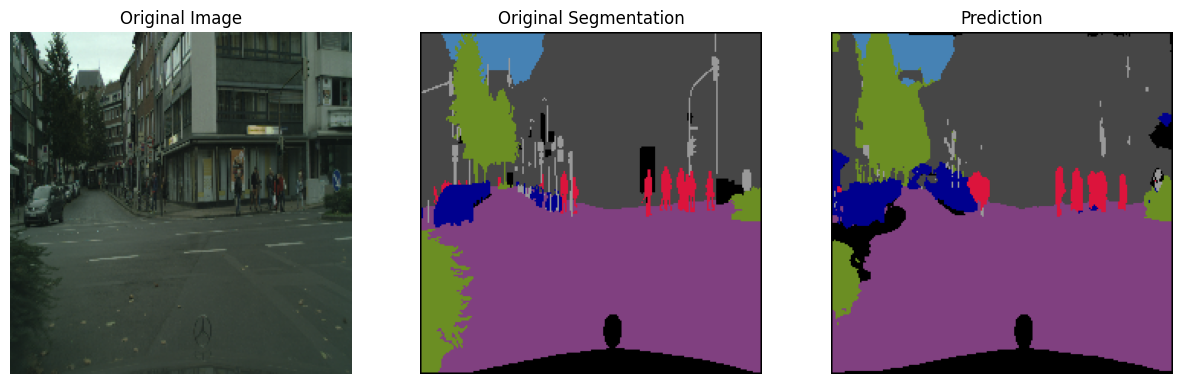

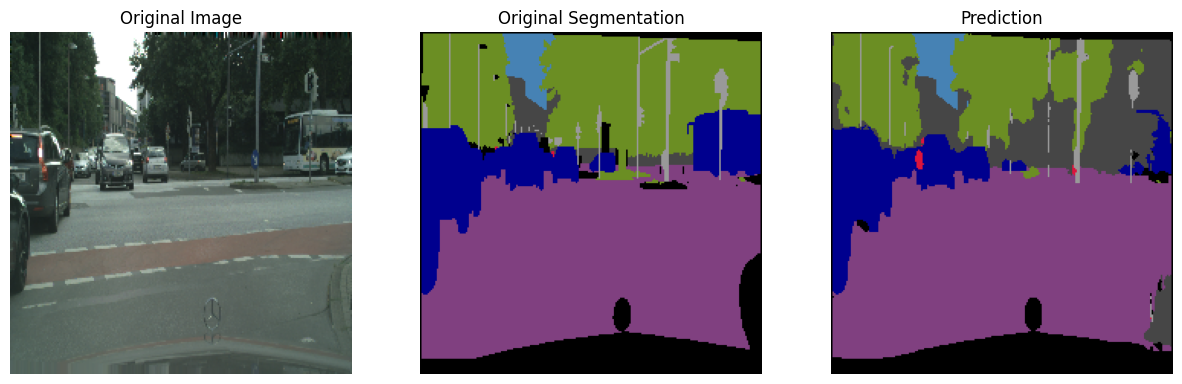

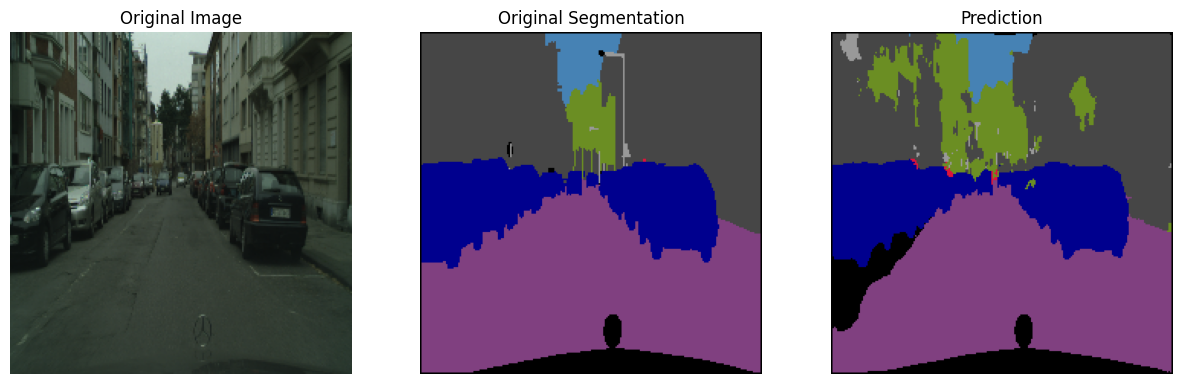

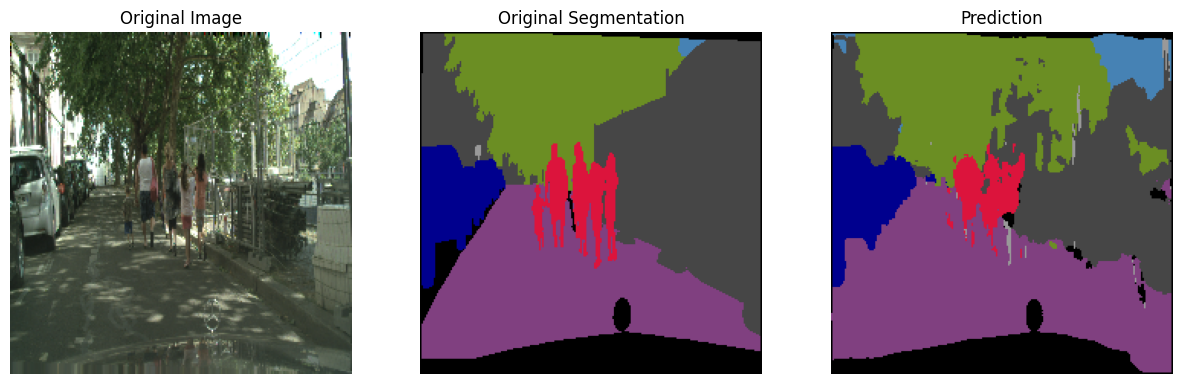

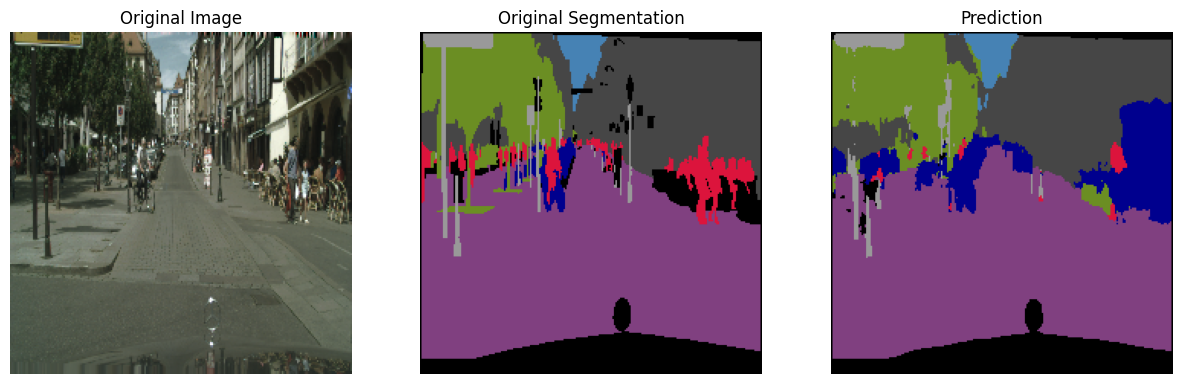

In [25]:
for image_draw_test, label_draw_test in list_data_for_draw_test:
            pred = best_model(image_draw_test.unsqueeze(0).to(device))
            pred = torch.argmax(pred, dim = 1).to("cpu")
            
            print("original", label_draw_test.unique())
            print("prediction", pred.unique())
            
            plot_result(image_draw_test, pred, label_draw_test)

In [26]:
pred = best_model(list_data_for_draw_test[3][0].unsqueeze(0).to(device))

In [27]:
pred = pred.squeeze()

In [28]:
pred.shape

torch.Size([8, 224, 224])

In [29]:
pred[:,115,115]

tensor([ 1.8548,  2.9973,  1.9440, -0.3233, -2.6828, -8.2508,  3.0808, -1.6411],
       device='cuda:0', grad_fn=<SelectBackward0>)